In [2]:
import sys
import os
import pandas as pd
import numpy as np
import pymc

sys.path.append(f'{os.path.dirname(os.path.dirname(os.getcwd()))}/draft_pick_prob')

In [3]:
draft_df = pd.read_csv('2019_draft_order.csv')
'''

mock_draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_BM_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_BM'})
mock_draft_df_2=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP'})
mock_draft_df_3=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_2CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP2'})
mock_draft_df_4=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_3CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP3'})
mock_draft_df_5=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_WW_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_W'})
'''
possible_players=pd.read_csv('2019_PLAYER_IDS.csv')

In [5]:

file_list =['2019_BM_mockdraft.csv','2019_CP_mockdraft.csv','2019_2CP_mockdraft.csv','2019_3CP_mockdraft.csv','2019_WW_mockdraft.csv','2019_SK_bb.csv','2019_HS_bb.csv','2019_2SK_bb.csv']

mock_draft_dfs = []


for filename in file_list:
    df = pd.read_csv(filename)  # Read the CSV file
    
    # Sort the DataFrame by 'RANK' column
    df = df.sort_values(by='RANK')
    
    prefix = filename[5:7]
        
    # Rename the 'RANK' column based on the extracted prefix
    if filename[-6:-4]== 'bb':
        df = df.rename(columns={'RANK': f'bb_RANK_{prefix}'})
    else:
        df = df.rename(columns={'RANK': f'md_RANK_{prefix}'})
    
    mock_draft_dfs.append(df)  # Add the processed DataFrame to the list



#possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv')
#draft_df
#possible_players

mock_draft_dfs[4]

,PLAYER_NAME,PLAYER_ID,md_RANK_WW
0,Jack Hughes,1,1
1,Kaapo Kakko,2,2
2,Alex Turcotte,5,3
3,Dylan Cozens,7,4
4,Bowen Byram,4,5
5,Trevor Zegras,9,6
6,Cole Caufield,15,7
7,Kirby Dach,3,8
8,Peyton Krebs,17,9
9,Matthew Boldy,12,10


In [6]:
import math
df_player_rankings=possible_players[['PLAYER_ID']].merge(mock_draft_dfs[0][['PLAYER_ID','md_RANK_BM']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[1][['PLAYER_ID','md_RANK_CP']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[2][['PLAYER_ID','md_RANK_2C']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[3][['PLAYER_ID','md_RANK_3C']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[4][['PLAYER_ID','md_RANK_WW']], how='left', on=['PLAYER_ID'])

df_player_rankings=df_player_rankings.merge(mock_draft_dfs[5][['PLAYER_ID','bb_RANK_SK']], how='left', on=['PLAYER_ID'])
#df_player_rankings=df_player_rankings.merge(mock_draft_dfs[6][['PLAYER_ID','bb_RANK_HS']], how='left', on=['PLAYER_ID'])
#df_player_rankings=df_player_rankings.merge(mock_draft_dfs[7][['PLAYER_ID','bb_RANK_2S']], how='left', on=['PLAYER_ID'])


df_player_rankings

PLAYER_ID  md_RANK_BM  md_RANK_CP  md_RANK_2C  md_RANK_3C  md_RANK_WW
0            1         1.0         1.0         1.0         1.0         1.0
1            2         2.0         2.0         2.0         2.0         2.0
2            3         5.0         5.0         8.0         5.0         8.0
3            4         3.0         4.0         5.0         3.0         5.0
4            5         4.0         3.0         3.0         4.0         3.0
..         ...         ...         ...         ...         ...         ...
224        222         NaN         NaN        89.0         NaN         NaN
225        223         NaN         NaN         NaN         NaN         NaN
226        224         NaN         NaN         NaN         NaN         NaN
227        225         NaN         NaN         NaN         NaN         NaN
228        226         NaN         NaN         NaN         NaN         NaN

[229 rows x 6 columns]

In [8]:
def likelihood(strengths, rankings):
    # params: vector of parameters [intercept, slope]
    likelihood=1
    counter=1
    paired_lists = list(zip(strengths, rankings))
    sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    while counter<len(sorted_list2)+1 and sorted_list2[counter]!=sorted_list2[counter+1]:

        likelihood+=np.log(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        counter+=1
    return likelihood

def neg_log_likelihood(params, df):
    neg_ll = 1  # Initialize as 0 for correct accumulation
    columns_to_go_through = df.columns[1:]
    for i in columns_to_go_through:
        max_rank = df[i].max() + 1
        player_rank = list(df[i])
        fixed_player_rank = [max_rank if math.isnan(x) else x for x in player_rank]
        
        # Determine the weighting factor based on column name
        if i.startswith('bb'):
            weight = 1  # Example: 0.5 for less value
        elif i.startswith('md'):
            weight = 1.0  # Example: 1.0 (or more) for 'md' columns
        else:
            weight = 1.0  # Default weight for other columns

        # Apply the weighting factor
        neg_ll -= weight * likelihood(params, fixed_player_rank)

    return neg_ll

In [9]:
def constraint_eq(x):
    return sum(x)

In [10]:
import scipy.optimize

counter=40
l_play=[]
variable_bounds=[]
count=0

while count<len(df_player_rankings):
    l_play.append(counter)
    count+=1
    counter-=0.20
    variable_bounds.append((-40,40))

result = scipy.optimize.minimize(neg_log_likelihood, l_play, args=(df_player_rankings,), method='SLSQP', bounds=variable_bounds, constraints={'type': 'eq', 'fun': constraint_eq})
print(result.x)

[ 40.          33.41742189  23.22084352  25.42516393  26.40348981
  17.48805037  23.82020838  19.10215778  22.11863311  19.51910174
  17.80279191  20.8899424   17.70232332  18.58160828  21.53414986
  18.45817979  21.70912447  17.15526076  13.88589128  16.04691603
  14.17017552  15.27363273  -1.58723386  16.60956166  14.0008056
  15.16020408  13.2063378   17.46771574  14.13209777   3.14668426
  14.45212396   3.30842468  18.59709361  16.66403907   3.36207241
   3.37056382   3.28437206  17.02343843   3.16075812  15.12710517
  12.9736925    3.21672542  13.94334049  13.75999925  13.32265622
  12.97368815   3.38410439   3.34621643  15.22566528   3.34259042
   3.40159857  13.09001268   3.5257051    3.64824824   3.66741914
  13.61739518   3.32246104   2.73213022   1.90591225   0.90210175
  -0.20091433  -1.24051388  -2.19760973  -3.01908738  -3.50617822
  -3.76329792  -3.71911627  -3.36818433  -2.78602163  -2.01445326
  -1.03565508  -0.05627983   1.01168707   1.946049    13.69093295
  12.975775

In [11]:
player_ability_parameters_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2019_validation/2019_PLAYER_IDS.csv')
player_ability_parameters_df['ABILITY_PARAMS']=result.x

player_ability_parameters_df=player_ability_parameters_df.sort_values(by='ABILITY_PARAMS', ascending=False, axis=0)
player_ability_parameters_df['SIM_RANK'] = range(1, len(player_ability_parameters_df) + 1)
player_ability_parameters_df.head(10)

,PLAYER_NAME,PLAYER_ID,ABILITY_PARAMS,SIM_RANK
0,Jack Hughes,1,40.000000,1
1,Kaapo Kakko,2,33.417422,2
4,Alex Turcotte,5,26.403490,3
3,Bowen Byram,4,25.425164,4
6,Dylan Cozens,7,23.820208,5
2,Kirby Dach,3,23.220844,6
8,Trevor Zegras,9,22.118633,7
16,Peyton Krebs,17,21.709124,8
14,Cole Caufield,15,21.534150,9
11,Matthew Boldy,12,20.889942,10


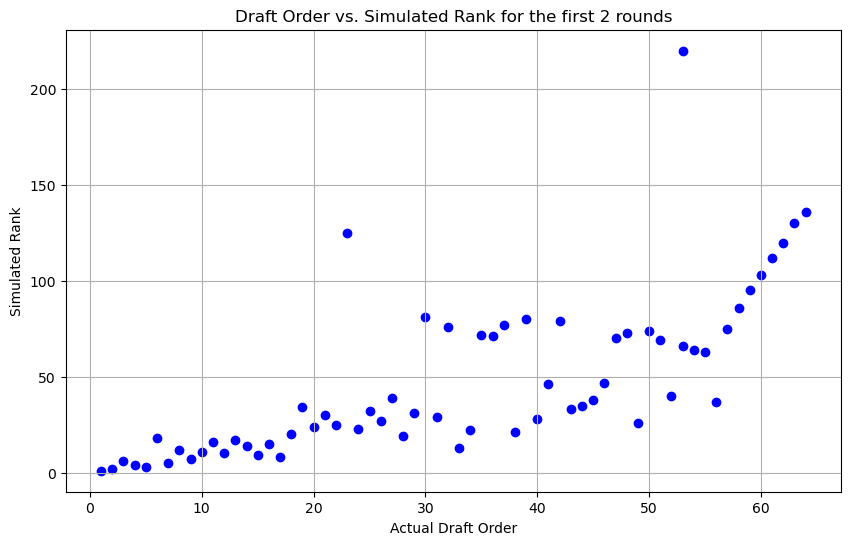

In [12]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')
merged_df
# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)


plt.show()




In [14]:
#Error -Mean absolute error (MAE)
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_NAME', 'ORDER']], on='PLAYER_NAME')
merged_df = merged_df.sort_values(by='ORDER')
merged_df = merged_df.head(32)
merged_df['ERROR'] = abs(merged_df['SIM_RANK']-merged_df['ORDER'])
mae = merged_df['ERROR'].sum()/len(merged_df['ERROR'])
print(mae)


#1.0 gives 8.4
#0.8 gives 7.72
#0.5 gives 7.97
#0.2 give 8.5 





10.46875
